In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
d0 = pd.read_csv('mnist_train.csv')

In [4]:
d0.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
d0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
#Seperated the label from actual dataset
label = d0['label']

In [9]:
d = d0.drop('label', axis=1)

In [13]:
print(d.shape)
print(label.shape)

(42000, 784)
(42000,)


C:\Users\AKSHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


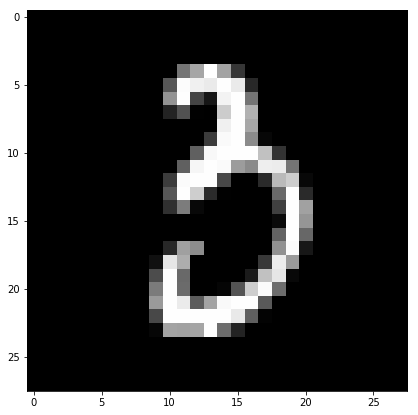

In [17]:
#Displaying the matrix data into plot
plt.figure(figsize=(7,7))
idx = 150

grid_data = d.iloc[idx].as_matrix().reshape(28,28)
plt.imshow(grid_data, interpolation='none', cmap='gray')
plt.show()



In [18]:
print(label.iloc[idx])

3


### MNIST using Trainer using Chainer framework

In [19]:
import math
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions


### 1. Prepare the dataset

In [20]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

### 2. Prepare the dataset iterations

In [24]:
batchsize = 128
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,False, False)

### 3. Prepare the model

In [27]:
class MLP(Chain):
    def __init__(self, n_mid_units = 100, n_out = 100):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(in_size=None, out_size=n_mid_units)
            self.l2 = L.Linear(in_size=None, out_size=n_mid_units)
            self.l3 = L.Linear(None, n_out)
    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
gpu_id = -1 #set to -1 if you use CPU and 0 for gpu

model = MLP()
if gpu_id >=0:
    model.to_gpu(gpu_id)
    

### 4. Prepare the Updater

In [28]:
max_epoch = 10

# Wrap your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss function here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

### 5. Setup Trainer

In [29]:
# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')


### 6. Add Extensions to the Trainer object

In [31]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### 7. Start Training

In [32]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.655663    0.820696       0.275934              0.918315                  3.98385       
1           0.655663    0.820696       0.275934              0.918315                  3.98385       
2           0.246186    0.928222       0.196863              0.940368                  8.89493       
2           0.246186    0.928222       0.196863              0.940368                  8.89493       
3           0.187331    0.946295       0.165118              0.949862                  13.7427       
3           0.187331    0.946295       0.165118              0.949862                  13.7427       
4           0.149734    0.95608        0.134074              0.959256                  19.7845       
4           0.149734    0.95608        0.134074              0.959256                 

### 8. Evaluate a pre-trained model

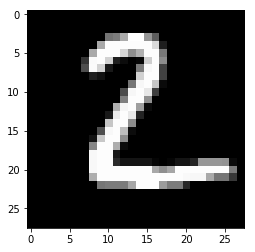

label: 2
predicted_label: 2


In [37]:
model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[1]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.array.argmax(axis=1)[0])